In [ ]:
# Read words from file
with open("brown_nouns.txt", "r") as file:
    words = [line.strip().lower() for line in file if line.strip()]


In [ ]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end = False
        self.freq = 0  # To keep track of branching frequency

class PrefixTrie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
            node.freq += 1
        node.is_end = True

    def collect_prefixes(self):
        """Traverse the prefix trie and collect all prefixes with their frequencies"""
        prefix_freq = {}

        def dfs(node, prefix):
            # record frequency only if more than 1 word shares this prefix
            if node.freq > 1:
                prefix_freq[prefix] = node.freq
            for ch, child in node.children.items():
                dfs(child, prefix + ch)

        for ch, child in self.root.children.items():
            dfs(child, ch)

        return prefix_freq




In [ ]:
class SuffixTrie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for char in reversed(word):
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
            node.freq += 1
        node.is_end = True

    def collect_suffixes(self, words):
        """Extract suffixes with frequencies using the suffix trie"""
        suffix_freq = defaultdict(int)
        for w in words:
            node = self.root
            path = ""
            for i, ch in enumerate(w[::-1]):  # reversed word
                node = node.children.get(ch)
                if not node:
                    break
                path += ch
                if len(node.children) > 1:  # branching = stem-suffix split
                    suffix = w[::-1][:i+1][::-1]  # reverse back suffix
                    suffix_freq[suffix] += 1
        return suffix_freq


In [ ]:
prefix_trie = PrefixTrie()
suffix_trie = SuffixTrie()

for word in words:
    prefix_trie.insert(word)
    suffix_trie.insert(word)


In [ ]:
def find_stem_suffix(word, trie, reverse=False):
    node = trie.root
    stem = ""
    max_branching = 0
    branch_point = 0

    chars = reversed(word) if reverse else word

    for i, char in enumerate(chars):
        if char in node.children:
            node = node.children[char]
            if len(node.children) > max_branching:
                max_branching = len(node.children)
                branch_point = i + 1
        else:
            break

    if reverse:
        stem = word[len(word)-branch_point:]
        suffix = word[:len(word)-branch_point]
    else:
        stem = word[:branch_point]
        suffix = word[branch_point:]



    return stem, suffix


In [ ]:
for word in words[:20]:  # Just check first 20 for demo
    stem_p, suf_p = find_stem_suffix(word, prefix_trie)
    stem_s, suf_s = find_stem_suffix(word, suffix_trie, reverse=True)
    print(f"{word} -> Prefix: {stem_p}+{suf_p},  Suffix: {suf_s}+{stem_s}")
    #print(prob_p)

investigation -> Prefix: in+vestigation,  Suffix: investigati+on
primary -> Prefix: p+rimary,  Suffix: primar+y
election -> Prefix: e+lection,  Suffix: electi+on
evidence -> Prefix: e+vidence,  Suffix: evidenc+e
irregularities -> Prefix: i+rregularities,  Suffix: irregularitie+s
place -> Prefix: p+lace,  Suffix: plac+e
jury -> Prefix: ju+ry,  Suffix: jur+y
presentments -> Prefix: p+resentments,  Suffix: presentment+s
charge -> Prefix: c+harge,  Suffix: charg+e
election -> Prefix: e+lection,  Suffix: electi+on
praise -> Prefix: p+raise,  Suffix: prais+e
thanks -> Prefix: t+hanks,  Suffix: thank+s
manner -> Prefix: ma+nner,  Suffix: mann+er
election -> Prefix: e+lection,  Suffix: electi+on
term -> Prefix: t+erm,  Suffix: ter+m
jury -> Prefix: ju+ry,  Suffix: jur+y
reports -> Prefix: re+ports,  Suffix: report+s
irregularities -> Prefix: i+rregularities,  Suffix: irregularitie+s
primary -> Prefix: p+rimary,  Suffix: primar+y
handful -> Prefix: ha+ndful,  Suffix: handfu+l


In [ ]:
def average_suffix_length(words, trie, reverse=False):
    total_len = 0
    for w in words:
        _, suffix = find_stem_suffix(w, trie, reverse)
        total_len += len(suffix)
    return total_len / len(words)

avg_pref = average_suffix_length(words, prefix_trie)
avg_suff = average_suffix_length(words, suffix_trie, reverse=True)

print(f"Avg suffix length (Prefix Trie): {avg_pref}")
print(f"Avg suffix length (Suffix Trie): {avg_suff}")


Avg suffix length (Prefix Trie): 5.153718323610775
Avg suffix length (Suffix Trie): 5.338626086699245


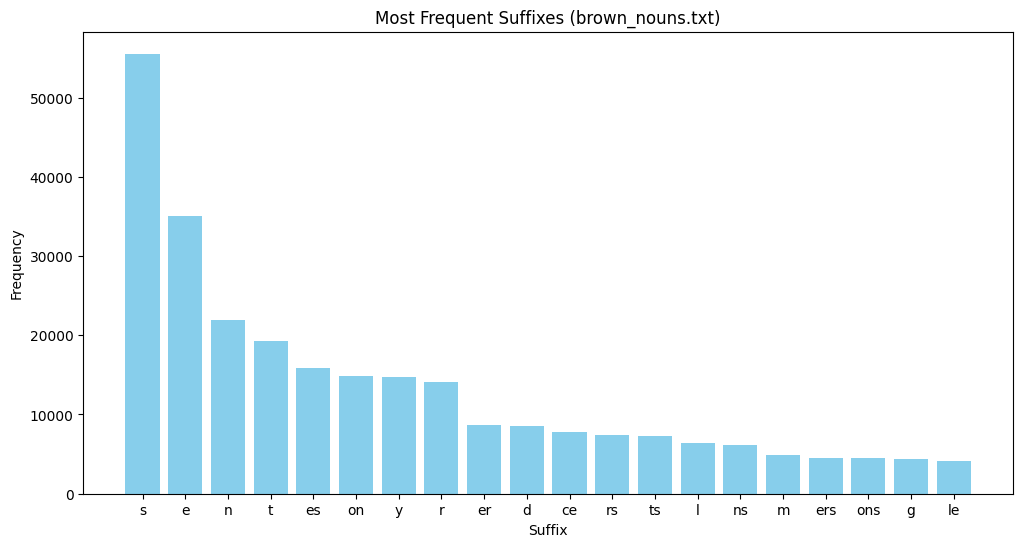

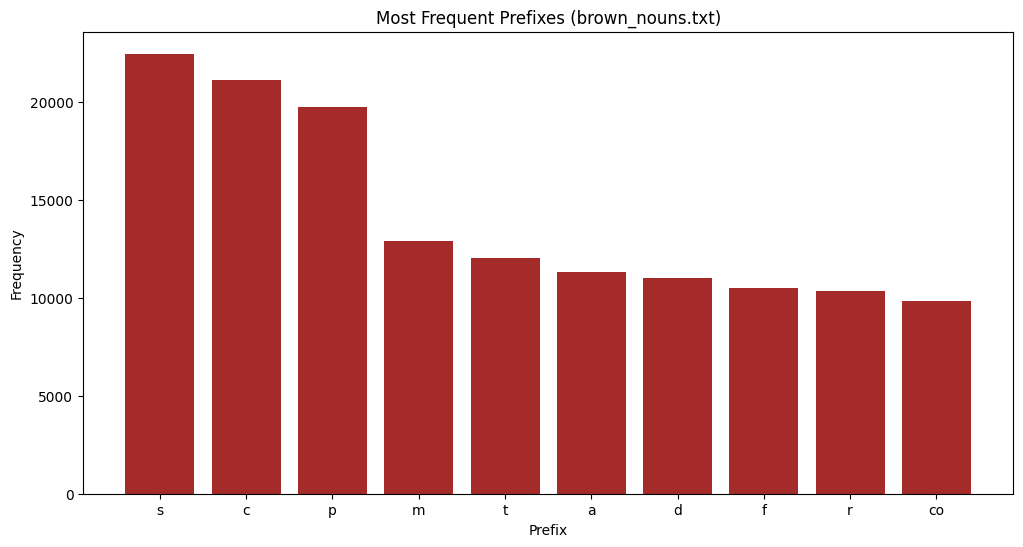

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

suffix_trie = SuffixTrie()
for w in words:
    suffix_trie.insert(w[::-1])
prefix_trie = PrefixTrie()
for w in words:
    prefix_trie.insert(w)

#collect suffix freq
suffix_freq = suffix_trie.collect_suffixes(words)
prefix_freq = prefix_trie.collect_prefixes()


#top 20
sorted_suffixes = sorted(suffix_freq.items(), key=lambda x: x[1], reverse=True)[:20]
suffixes, counts = zip(*sorted_suffixes)
sorted_prefixes = sorted(prefix_freq.items(), key=lambda x: x[1], reverse=True)[:10]
prefixes, counts1 = zip(*sorted_prefixes)

plt.figure(figsize=(12,6))
plt.bar(suffixes, counts, color="skyblue")
plt.title("Most Frequent Suffixes (brown_nouns.txt)")
plt.xlabel("Suffix")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(prefixes, counts1, color="brown")
plt.title("Most Frequent Prefixes (brown_nouns.txt)")
plt.xlabel("Prefix")
plt.ylabel("Frequency")
plt.show()

In [2]:
# =========================================
# Trie-based Stemming with Prefix & Suffix
# Works directly on PDF dataset (brown_nouns.pdf)
# =========================================

!pip install PyPDF2

import PyPDF2

# ------------------------------
# Step 1: Extract words from PDF
# ------------------------------
def extract_words_from_pdf(pdf_path):
    words = []
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text = page.extract_text()
            if text:
                for token in text.split():
                    token = token.strip().lower()
                    if token.isalpha():   # keep only alphabetic words
                        words.append(token)
    return words

words = extract_words_from_pdf("brown_nouns.pdf")
print("✅ Total words extracted:", len(words))
print("Sample:", words[:20])

# Save all words into output.txt
with open("output.txt", "w") as f:
    for w in words:
        f.write(w + "\n")
print("✅ Saved all words into output.txt")


# ------------------------------
# Step 2: Trie Implementation
# ------------------------------
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end = False
        self.freq = 0   # frequency of words passing through this node

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for ch in word:
            if ch not in node.children:
                node.children[ch] = TrieNode()
            node = node.children[ch]
            node.freq += 1
        node.is_end = True

    def find_stem_suffix(self, word):
        """
        Find stem+suffix split based on max branching (node with max children).
        """
        node = self.root
        max_branch = -1
        split_index = len(word)  # default = whole word is stem

        for i, ch in enumerate(word):
            if ch not in node.children:
                break
            node = node.children[ch]

            # branching = number of children at this node
            branching = len(node.children)
            if branching > max_branch:
                max_branch = branching
                split_index = i + 1

        stem = word[:split_index]
        suffix = word[split_index:]
        return stem, suffix, max_branch, node.freq


# ------------------------------
# Step 3: Prefix & Suffix Trie Builders
# ------------------------------
def build_prefix_trie(words):
    trie = Trie()
    for w in words:
        trie.insert(w)
    return trie

def build_suffix_trie(words):
    trie = Trie()
    for w in words:
        trie.insert(w[::-1])  # insert reversed
    return trie


# ------------------------------
# Step 4: Process with Prefix & Suffix Tries
# ------------------------------
def process_prefix(words, trie):
    result = []
    for w in words:
        stem, suffix, branch, freq = trie.find_stem_suffix(w)
        result.append(f"{w} = {stem}+{suffix}  (branch={branch}, freq={freq})")
    return result

def process_suffix(words, trie):
    result = []
    for w in words:
        stem, suffix, branch, freq = trie.find_stem_suffix(w[::-1])
        suffix = suffix[::-1]  # reverse back
        stem = w[:len(w)-len(suffix)]
        result.append(f"{w} = {stem}+{suffix}  (branch={branch}, freq={freq})")
    return result


# ------------------------------
# Step 5: Run & Compare
# ------------------------------
prefix_trie = build_prefix_trie(words)
suffix_trie = build_suffix_trie(words)

prefix_results = process_prefix(words, prefix_trie)
suffix_results = process_suffix(words, suffix_trie)

print("\n--- Prefix Trie Results (sample 10) ---")
for line in prefix_results[:10]:
    print(line)

print("\n--- Suffix Trie Results (sample 10) ---")
for line in suffix_results[:10]:
    print(line)

# Compare performance
better_prefix = sum(1 for r in prefix_results if "+" in r)
better_suffix = sum(1 for r in suffix_results if "+" in r)

comparison_summary = [
    "\n--- Stemming Comparison ---",
    f"Prefix Trie gave splits for {better_prefix}/{len(words)} words",
    f"Suffix Trie gave splits for {better_suffix}/{len(words)} words"
]

if better_prefix > better_suffix:
    comparison_summary.append("👉 Prefix Trie works better for stemming.")
elif better_suffix > better_prefix:
    comparison_summary.append("👉 Suffix Trie works better for stemming.")
else:
    comparison_summary.append("👉 Both perform equally well.")


# ------------------------------
# Step 6: Save Full Report
# ------------------------------
with open("report1.txt", "w") as f:
    f.write("=== Report on Prefix vs Suffix Trie Stemming ===\n\n")
    f.write("Total Words Extracted: " + str(len(words)) + "\n\n")

    f.write("---- Prefix Trie Results ----\n")
    for line in prefix_results:
        f.write(line + "\n")

    f.write("\n---- Suffix Trie Results ----\n")
    for line in suffix_results:
        f.write(line + "\n")

    f.write("\n".join(comparison_summary) + "\n")

print("✅ Report saved as report1.txt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.4 MB/s eta 0:00:00
✅ Total words extracted: 201654
Sample: ['investigation', 'primary', 'election', 'evidence', 'irregularities', 'place', 'jury', 'presentments', 'charge', 'election', 'praise', 'thanks', 'manner', 'election', 'term', 'jury', 'reports', 'irregularities', 'primary', 'handful']
✅ Saved all words into output.txt

--- Prefix Trie Results (sample 10) ---
investigation = in+vestigation  (branch=23, freq=65)
primary = p+rimary  (branch=14, freq=15)
election = e+lection  (branch=22, freq=125)
evidence = e+vidence  (branch=22, freq=207)
irregularities = i+rregularities  (branch=12, freq=8)
place = p+lace  (branch=14, freq=580)
jury = ju+ry  (branch=13, freq=63)
presentments = pre+sentments  (branch=15, freq=1)
charge = c+harge  (branch=14, freq=147)
election = e+lection  (branch=22, freq=125)

--- Suffix Trie Results (sample 10) ---
investigation = in+investigati  (branch=18, freq=44)
primary = p+primar  (branch=22, f

**QUESTION 2**

✅ Total documents loaded: 10000
Sample: [{'document_id': 0, 'original_text': 'लोगों को बिलों संबंधी सुविधा देना ही उनका काम', 'sentences': [{'text': 'लोगों को बिलों संबंधी सुविधा देना ही उनका काम', 'tokens': ['लोगों', 'को', 'बिलों', 'संबंधी', 'सुविधा', 'देना', 'ही', 'उनका', 'काम'], 'word_count': 9}], 'document_stats': {'sentence_count': 1, 'word_count': 9, 'character_count': 45}}, {'document_id': 1, 'original_text': 'इनेलो 1987 में उस वक्त ऐसे ही दोराहे पर खड़ी थी, जब पूर्व उपप्रधानमंत्री देवीलाल ने अपने पुत्र ओमप्रकाश चौटाला को अपना राजनीतिक उत्तराधिकारी घोषित किया था। हालांकि तब पार्टी पर देवीलाल की मजबूत पकड़ के चलते पार्टी टूटने से बच गई थी। 1989 में देवीलाल केन्द्र की राजनीति में सक्रिय हो गए थे और उनके उपप्रधानमंत्री बनने के पश्चात् उनके तीन बेटों जगदीश सिंह, रणजीत सिंह और ओमप्रकाश चौटाला में से रणजीत और ओमप्रकाश के बीच हरियाणा में उनकी राजनीतिक विरासत को लेकर जंग शुरू हो गई थी। उन परिस्थितियों में देवीलाल ने कड़ा निर्णय लेते हुए पार्टी की बागडोर ओमप्रकाश चौटाला के हवाले कर दी थी

/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

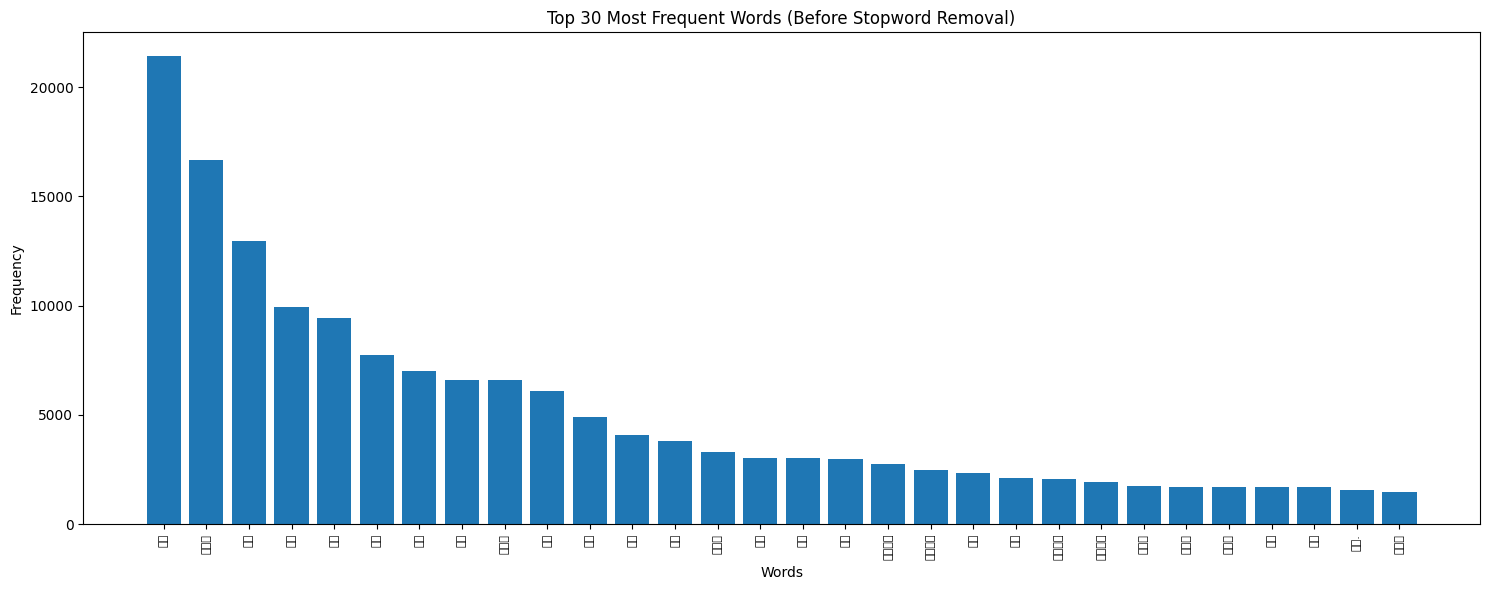

/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2313 (\N{DEVANAGARI LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2312 (\N{DEVANAGARI LETTER II}) missing from font(s) DejaVu Sans.
  plt.tight_layou

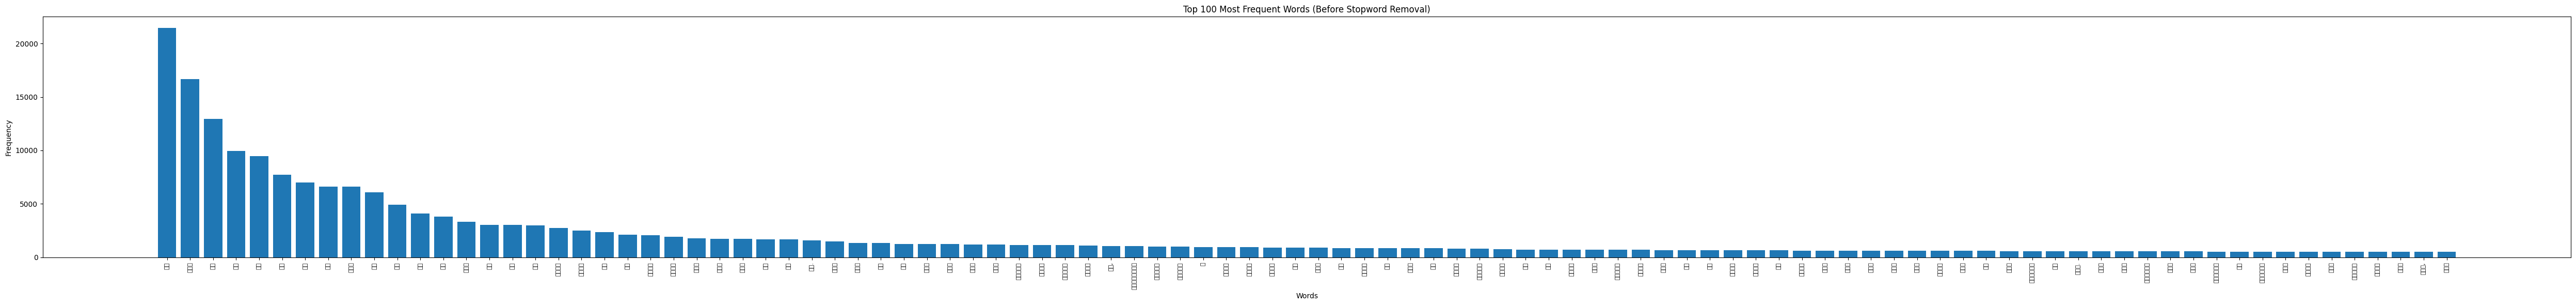

/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2343 (\N{DEVANAGARI LETTER DHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2359 (\N{DEVANAGARI LETTER SSA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2396 (\N{DEVANAGARI LETTER DDDHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:64: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from font(s) DejaVu Sans.
  plt.savefi

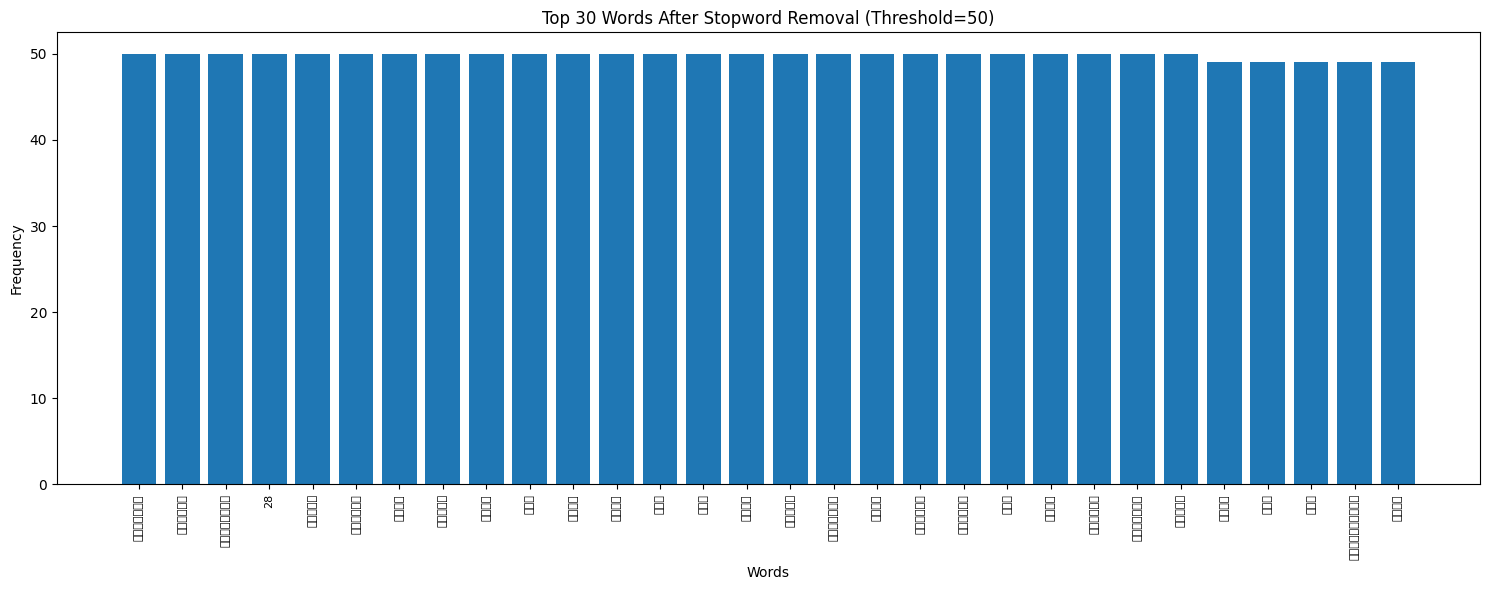

/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2347 (\N{DEVANAGARI LETTER PHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:64: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300)
/tmp/ipython-input-3398138060.py:64: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300)
/tmp/ipython-input-3398138060.py:64: UserWarning: Glyph 2347 (\N{DEVANAGARI LETTER PHA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2326 (\

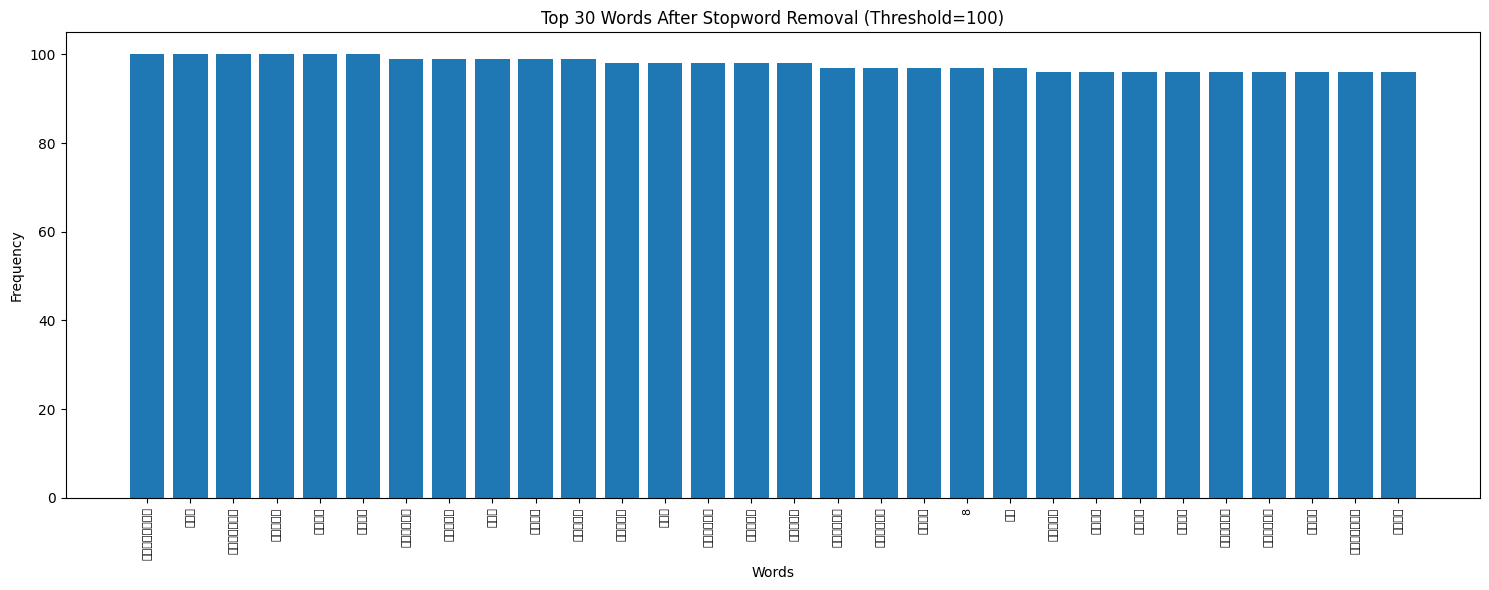

/tmp/ipython-input-3398138060.py:63: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3398138060.py:64: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


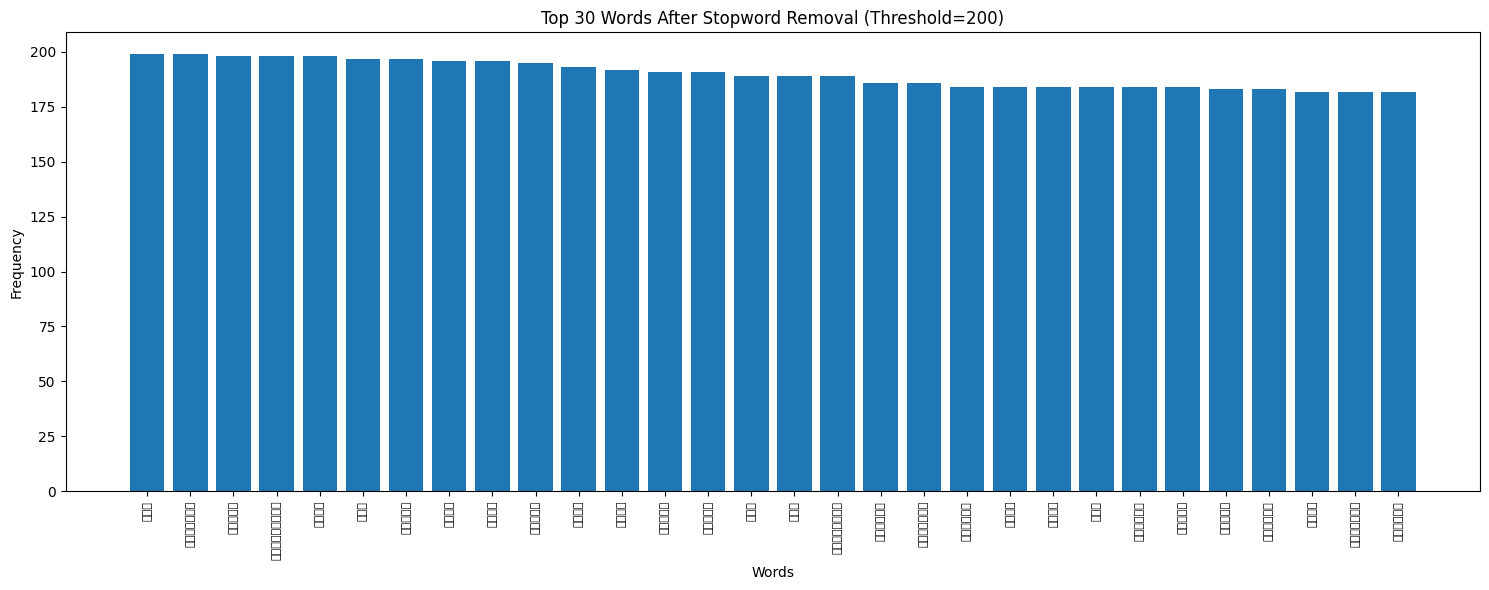

✅ Report saved to report.txt


In [1]:
# ==========================================
# Assignment: Frequency Distribution & Stopword Removal
# Input: tokenised_data_final.json (with {document_id, original_text})
# ==========================================

import json
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Load Data
# ---------------------------
with open("tokenized_data_final.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print("✅ Total documents loaded:", len(data))
print("Sample:", data[:2])   # check structure

# ---------------------------
# Step 2: Extract Tokens
# ---------------------------
tokens = []
for entry in data:
    if "original_text" in entry:
        text = entry["original_text"]
        words = text.strip().lower().split()   # simple whitespace split
        tokens.extend(words)

print("✅ Total tokens extracted:", len(tokens))
print("Sample tokens:", tokens[:30])

# ---------------------------
# Step 3: Frequency Distribution
# ---------------------------
freq_dist = {}
for word in tokens:
    if word in freq_dist:
        freq_dist[word] += 1
    else:
        freq_dist[word] = 1

print("✅ Unique words:", len(freq_dist))

# Save frequency distribution
with open("freq_distribution.txt", "w", encoding="utf-8") as f:
    for w, c in sorted(freq_dist.items(), key=lambda x: x[1], reverse=True):
        f.write(f"{w}\t{c}\n")
print("✅ Frequency distribution saved to freq_distribution.txt")


# ---------------------------
# Step 4: Plot Function
# ---------------------------
def plot_top_words(freq_dict, title, filename, top_n=30):
    sorted_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    words, counts = zip(*sorted_words)

    plt.figure(figsize=(max(12, top_n//2), 6))
    plt.bar(words, counts)
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Before stopword removal
plot_top_words(freq_dist, "Top 30 Most Frequent Words (Before Stopword Removal)", "top30_before.png", top_n=30)
plot_top_words(freq_dist, "Top 100 Most Frequent Words (Before Stopword Removal)", "top100_before.png", top_n=100)


# ---------------------------
# Step 5: Stopword Removal
# ---------------------------
def remove_stopwords(freq_dict, threshold):
    return {w: c for w, c in freq_dict.items() if c <= threshold}

thresholds = [50, 100, 200]  # adjust for your dataset size
report_lines = []

for t in thresholds:
    reduced = remove_stopwords(freq_dist, t)
    report_lines.append(f"Threshold {t}: {len(freq_dist)-len(reduced)} stopwords removed, {len(reduced)} words remain.")
    plot_top_words(reduced, f"Top 30 Words After Stopword Removal (Threshold={t})", f"top30_after_{t}.png", top_n=30)

# ---------------------------
# Step 6: Save Report
# ---------------------------
with open("report.txt", "w", encoding="utf-8") as f:
    f.write("=== Word Frequency & Stopword Removal Report ===\n\n")
    f.write(f"Total tokens: {len(tokens)}\n")
    f.write(f"Unique words: {len(freq_dist)}\n\n")

    f.write("Stopword Removal Summary:\n")
    for line in report_lines:
        f.write(line + "\n")

print("✅ Report saved to report.txt")